In [1]:
from choquet_integral import *
import numpy as np
import cv2
import itertools
import math
import inspect
import matplotlib.pyplot as plt
import csv
import sklearn.metrics as metrics
from scipy.stats import entropy
import random
import xai_indices as xai
import pyemd
from sklearn import datasets
from emd_clustertend import vat, ivat, emd_pairwise_dissimilarity
from sklearn.preprocessing import scale
import scipy.io as sio

In [2]:
def random_node_fm(n):
    ch = ChoquetIntegral()
    ch.type='quad'
    ch.fm = {}
    ch.fm[str(np.arange(1,n+1))] = 1
    ch.fm['[]'] = 0
    ch.N = n
    ch.M = n
    numkeys = len(ch.get_keys_index())
    keys = list(ch.get_keys_index().keys())
    keys.append('[]')
    s = [0] * (numkeys + 1)
    s[-1] = 1
    s[-2] = 1
    done = False
    while not done:
        randindex = random.randrange(0,numkeys)
        if s[randindex] == 0:
            s[randindex] = 1
            if keys[randindex] != '[]':
                compare_key = [int(s) for s in keys[randindex][1:-1].split() if s.isdigit()]

            else:
                compare_key = []

            maxi = 0
            max_index = 0
            mini = 1
            min_index = 0
            for i,key in enumerate(keys):
                if s[i] == 1 and i != randindex:
                    if key != '[]':
                        stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
                    else:
                        stripped = []

                    if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] >= maxi:
                        maxi = ch.fm[key]
                        max_index = i
                    if is_subset(compare_key,stripped) and s[i] == 1 and ch.fm[key] <= mini:

                        mini = ch.fm[key]
                        min_index = i


            rb = ch.fm[keys[max_index]]
            ru = ch.fm[keys[min_index]]
            g = random.uniform(rb,ru)
            ch.fm[keys[randindex]] = g

        else:
            pass
        if min(s) == 1:
            done = True
    return ch

# a is subset of b
def is_subset(a,b):
    if len(a) == 0:
        return True
    if len(b) == 0 and len(a) != 0:
        return False
    for val in a:
        if val not in b:
            return False
    else:
        return True
    
def sample_with_noise(ch,data,mean,var):
    labels = np.zeros(data.shape[0])
    for i,point in enumerate(data):
        labels[i] = max(min(ch.chi_quad(point) + random.gauss(mean,var),1),0)
    return labels

def gen_datapoints(m,n):
    points = []
    for i in range(n):
        point = []
        for j in range(m):
            point.append(random.random())
        points.append(point)
    return np.asarray(points)

def percentage_walks_observed(walks):
    seen = 0
    total = 0
    for key in walks.keys():
        if walks[key] > 0:
            seen = seen + 1
        total = total+1
    return seen/total

def read_crisp(fname):
    part = []
    with open(fname) as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        for row in reader:
            part.append(row)
    return np.asarray(part,dtype=int)
crisp_part = read_crisp("crisp.csv")

#input: crisp partition matrix, reordering from odm to dm, odm itself
def center_from_crisp(crisp,reordering,odm):
    n = crisp.shape[0]
    row = 0
    num_in_cluster = 0
    cluster_centers = []
    for i in range(n):
        if crisp[row][i] == 1:
            num_in_cluster = num_in_cluster + 1
            
        else:
#             print("new cluster at", i)
            mini = np.inf
            mini_row = row
            for j in range(row,row+num_in_cluster):
                row_sum = np.sum(odm[j][i-num_in_cluster:i])
                if row_sum < mini:
                    mini = row_sum
                    mini_row = j
            cluster_centers.append(reorder[mini_row][0][0])   #the center is row w/ minimum difference, put back in unordered
            row = row+num_in_cluster
            num_in_cluster = 1
            
    mini = np.inf
    mini_row = row
    for j in range(row,row+num_in_cluster):
        row_sum = np.sum(odm[j][i-num_in_cluster+1:i+1])
#         print(row_sum, "sum of row", j)
        if row_sum < mini:
            mini = row_sum
            mini_row = j
    cluster_centers.append(reorder[mini_row][0][0])
    return cluster_centers

def generate_walk_diffs(chi):
    n = chi.M
    initial = []
    for i in range(n):
        initial.append(i+1)

    index_permutations = itertools.permutations(initial,n)
    walks = np.ndarray((math.factorial(n),n),dtype=int)
    walk_diffs = np.ndarray((math.factorial(n),n),dtype=float)
    for i,val in enumerate(index_permutations):
        walks[i] = np.asarray(val)

        c_build = np.ndarray(n)
        for j in range(len(walks[i])):
            if j == 0:
                c_build[j] = chi.fm[str(walks[i][0:1])]
            else:
                c_build[j] = (chi.fm[str(np.sort(walks[i][0:j+1]))]) - (chi.fm[str(np.sort(walks[i][0:j]))])

        walk_diffs[i] = c_build
    return walk_diffs


def gen_seen_walk_diffs(walk_visitation,ch):
    seen_walks = []
    for walk in walk_visitation.keys():
        if walk_visitation[walk] > 0:
            seen_walks.append(walk)
    
    n = len(seen_walks[0])
    walk_diffs = np.ndarray((len(seen_walks),n),dtype=float)
    for i,walk in enumerate(seen_walks):
        walk = list(walk)
        c_build = np.ndarray(n)
        for j in range(len(walk)):
            if j == 0:
                c_build[j] = ch.fm[str(walk[0:1])]
            else:
                c_build[j] = ch.fm[str(np.sort(walk[0:j+1]))] - ch.fm[str(np.sort(walk[0:j]))]
        walk_diffs[i] = c_build
    return walk_diffs

def gen_seen_walk_diffs_2(walk_visitation,ch):
    seen_walks = []
    for walk in walk_visitation:
        if walk_visitation[walk] > 0:
            seen_walks.append(walk)
    
    n = len(seen_walks[0])
    walk_diffs = np.ndarray((len(seen_walks),n),dtype=float)
    for i,walk in enumerate(seen_walks):
        walk = list(walk)
        c_build = np.ndarray(n)
        for j in range(len(walk)):
            if j == 0:
                c_build[j] = ch.fm[str(walk[0:1])]
            else:
                c_build[j] = ch.fm[str(np.sort(walk[0:j+1]))] - ch.fm[str(np.sort(walk[0:j]))]
        walk_diffs[i] = c_build
    return walk_diffs
        

In [3]:
split_owa = ChoquetIntegral()
split_owa.N = 5
split_fm = {}
split_fm[str(np.asarray([1]))] = .1
split_fm[str(np.asarray([2]))] = .1
split_fm[str(np.asarray([3]))] = .1
split_fm[str(np.asarray([4]))] = .1
split_fm[str(np.asarray([5]))] = .1
split_fm[str(np.asarray([1,2]))] = .2
split_fm[str(np.asarray([1,3]))] = .2
split_fm[str(np.asarray([1,4]))] = .2
split_fm[str(np.asarray([1,5]))] = .2
split_fm[str(np.asarray([2,3]))] = .2
split_fm[str(np.asarray([2,4]))] = .4
split_fm[str(np.asarray([2,5]))] = .4
split_fm[str(np.asarray([3,4]))] = .4
split_fm[str(np.asarray([3,5]))] = .4
split_fm[str(np.asarray([4,5]))] = .4
split_fm[str(np.asarray([1,2,3]))] = .6
split_fm[str(np.asarray([1,2,4]))] = .6
split_fm[str(np.asarray([1,2,5]))] = .6
split_fm[str(np.asarray([1,3,4]))] = .6
split_fm[str(np.asarray([1,3,5]))] = .6
split_fm[str(np.asarray([1,4,5]))] = .6
split_fm[str(np.asarray([2,3,4]))] = .6
split_fm[str(np.asarray([2,3,5]))] = .6
split_fm[str(np.asarray([2,4,5]))] = .6
split_fm[str(np.asarray([3,4,5]))] = .6
split_fm[str(np.asarray([1,2,3,4]))] = .6
split_fm[str(np.asarray([1,2,3,5]))] = .6
split_fm[str(np.asarray([1,2,4,5]))] = .6
split_fm[str(np.asarray([1,3,4,5]))] = .9
split_fm[str(np.asarray([2,3,4,5]))] = .9
split_fm[str(np.asarray([1,2,3,4,5]))] = 1
split_owa.fm = split_fm
split_owa.type ='quad'

Number Inputs :  5 ; Number Samples :  300
     pcost       dcost       gap    pres   dres
 0: -6.6084e+01 -8.1329e+01  1e+02  9e+00  3e-01
 1: -6.5428e+01 -8.2011e+01  3e+01  1e+00  5e-02
 2: -6.6067e+01 -6.9764e+01  4e+00  5e-02  1e-03
 3: -6.6311e+01 -6.7115e+01  8e-01  7e-03  2e-04
 4: -6.6390e+01 -6.6770e+01  4e-01  7e-05  2e-06
 5: -6.6405e+01 -6.6435e+01  3e-02  5e-06  1e-07
 6: -6.6407e+01 -6.6409e+01  1e-03  1e-07  3e-09
 7: -6.6407e+01 -6.6407e+01  6e-05  1e-09  3e-11
Optimal solution found.
0.8916666666666667


100%|████████████████████████████████████████████████████████████████████████| 14400/14400 [00:00<00:00, 481827.00it/s]

starting step 2
starting step 3



100%|████████████████████████████████████████████████████████████████████████| 14400/14400 [00:00<00:00, 465767.83it/s]

starting step 2
starting step 3


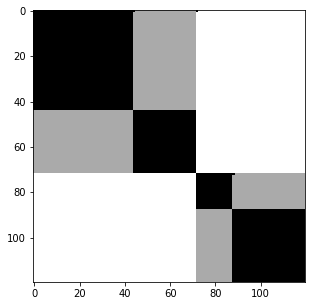

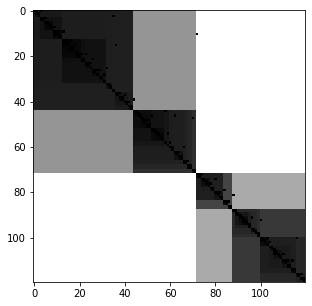

In [4]:
data = gen_datapoints(5,300)
noisy_labels = sample_with_noise(split_owa,data,0,.025)

noisy_split_owa = ChoquetIntegral()
noisy_split_owa.train_chi(data.T,noisy_labels)

(walks,_) = xai.walk_visitation(data.T)
# print(walks)
print(percentage_walks_observed(walks))

owa_diffs = split_owa.generate_walk_diffs()
ivat(owa_diffs,figure_size=(5,5))
noisy_owa_diffs = noisy_split_owa.generate_walk_diffs()
odm = ivat(noisy_owa_diffs,figure_size=(5,5),return_odm=True)

In [48]:
#Read in the variables for a FM

airfoil_bias = 0
with open("yacht.csv",'r') as csvfile:
    reader = csv.reader(csvfile)
    fm_vars = []
    for row in reader:
        fm_vars.append(row[1])
    airfoil_bias = fm_vars[-1]

airfoil_noreg_bias = 0
with open("yacht_noreg.csv",'r') as csvfile:
    reader = csv.reader(csvfile)
    noreg_fm_vars = []
    for row in reader:
        noreg_fm_vars.append(row[1])
    airfoil_noreg_bias = noreg_fm_vars[-1]
        
with open("yacht_sort.csv",'r') as csvfile:
    reader = csv.reader(csvfile)
    sorts = []
    for row in reader:
        introw = [int(x) for x in row]
        sorts.append(introw)


sorts = [tuple(sort) for sort in sorts]
print(len(set(sorts)) / math.factorial(6))

0.10694444444444444


In [49]:
#Create choquet integral object, create FM
airfoil_ch = ChoquetIntegral()
airfoil_ch.N = 6
airfoil_fm = {}
for i,key in enumerate(airfoil_ch.get_keys_index()):
    airfoil_fm[key] = float(fm_vars[i+1])
    
airfoil_ch.fm = airfoil_fm

#Enumerate walks and generate array of LOSs
airfoil_diffs = airfoil_ch.generate_walk_diffs()

airfoil_bias_diffs = np.zeros((np.shape(airfoil_diffs)[0],np.shape(airfoil_diffs)[1]+1))

for i,diff in enumerate(airfoil_diffs):
    airfoil_bias_diffs[i] = np.append(diff,airfoil_bias)
    
airfoil_bias_diffs.shape

# print(airfoil_diffs)

#dissimilarity matrix can be created by metrics.pairwise_distances(airfoil_diffs)
# i.e. airfoil_diffs is shape (120,5), dissimilarity matrix would be (120,120)

# ivat(airfoil_diffs,euclidean=True)
#the python ivat library we found sucks (not symmetric), so we have to export to matlab to generate plots



(720, 7)

In [50]:
airfoil_noreg = ChoquetIntegral()
airfoil_noreg.N = 6
airfoil_noreg.get_keys_index()
airfoil_noreg_fm = {}
for i,key in enumerate(airfoil_noreg.get_keys_index()):
    airfoil_noreg_fm[key] = float(noreg_fm_vars[i+1])
    
airfoil_noreg.fm = airfoil_noreg_fm

airfoil_noreg_diffs = airfoil_noreg.generate_walk_diffs()


airfoil_bias_noreg_diffs = np.zeros((np.shape(airfoil_diffs)[0],np.shape(airfoil_diffs)[1]+1))

for i,diff in enumerate(airfoil_noreg_diffs):
    airfoil_bias_noreg_diffs[i] = np.append(diff,airfoil_noreg_bias)
    

# ivat(airfoil_noreg_diffs,euclidean=True)



In [52]:

def gen_seen_walk_diffs_2(seen_walks,ch):

    n = len(seen_walks[0])
    walk_diffs = np.ndarray((len(seen_walks),n),dtype=float)
    for i,walk in enumerate(seen_walks):
        walk = list(walk)
        c_build = np.ndarray(n)
        for j in range(len(walk)):
            if j == 0:
                c_build[j] = ch.fm[str(walk[0:1])]
            else:
                c_build[j] = ch.fm[str(np.sort(walk[0:j+1]))] - ch.fm[str(np.sort(walk[0:j]))]
        walk_diffs[i] = c_build
    return walk_diffs


airfoil_seen_diss = metrics.pairwise_distances(gen_seen_walk_diffs_2(list(set(sorts)),airfoil_ch))
airfoil_noreg_seen_diss = metrics.pairwise_distances(gen_seen_walk_diffs_2(list(set(sorts)),airfoil_noreg))

airfoil_all_diss = metrics.pairwise_distances(airfoil_bias_diffs)
airfoil_noreg_all_diss = metrics.pairwise_distances(airfoil_bias_noreg_diffs)


airfoil_mat = {}
airfoil_mat["yacht_seen_diss"] = airfoil_seen_diss
airfoil_mat["yacht_noreg_seen_diss"] = airfoil_noreg_seen_diss
airfoil_mat["yacht_all_diss"] = airfoil_all_diss
airfoil_mat["yacht_noreg_all_diss"] = airfoil_noreg_all_diss
sio.savemat("yacht.mat",airfoil_mat)